## Combining Methods: Ensembles

In [ ]:
# Import required packages for this chapter
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pylab as plt

from dmba import classificationSummary
from dmba import liftChart, gainsChart

%matplotlib inline

In [29]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('/Users/ujjwalsharma/207 class/Homework /ensemble')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

# eBay Auctions
Using the eBay auction data (file _eBayAuctions.csv_) with variable Competitive as the outcome variable, partition the data into training (60%) and validation (40%).

In [30]:
ebay_df = pd.read_csv(DATA / 'eBayAuctions.csv')
ebay_df.head()

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


## (a)
Tune hyperparameters to train a single Decision Tree using `DecisionTreeClassifier()`.
Looking at the validation data, what is the overall accuracy? Produce the gains and lift charts for the validation data. What is the lift on the first decile? Also report F1-Score (especially useful if the classes are imbalanced) and Tree Depth (from the best model)

In [31]:

ebay_df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


In [32]:
X=pd.get_dummies(ebay_df.drop(columns=['ClosePrice','Competitive?']), drop_first=True)
y=ebay_df['Competitive?']
 # spliting the data 40 percent for validation with a random state of 1 to reproduce the results
train_X, valid_X, train_y, valid_y = train_test_split(
    X, y, test_size=0.40, random_state=1)

# had to get dummies because i was getting an error due to categories having a different values and deleted ClosingPrice because we are trying to predict competitiviness at the start of the auction. 

Best Decision Tree with GridSearch: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}
Confusion Matrix (Accuracy 0.7009)

       Prediction
Actual   0   1
     0 262  91
     1 145 291

Validation accuracy for the best Decision Tree: 0.7009
Validation F1 for the best Decision Tree: 0.7115


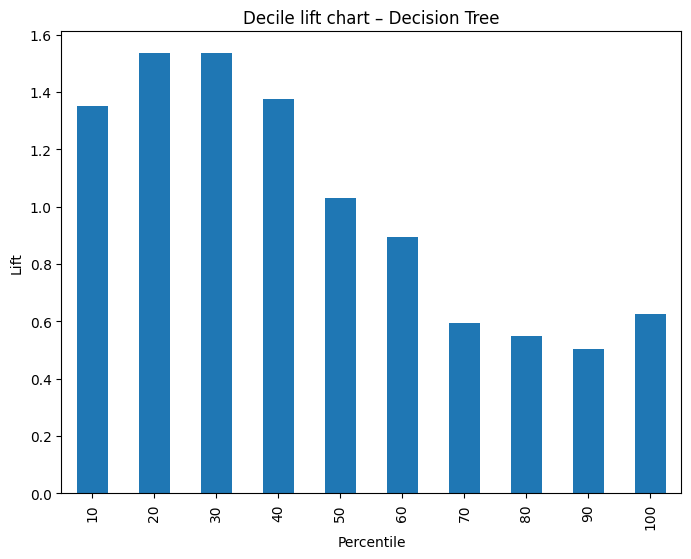

In [36]:


#  Grid-search a for DecisionTreeClassifier
tree_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
}
# implementing grid search with 5-fold cross-validation
tree_cv_search = GridSearchCV(
    DecisionTreeClassifier(random_state=1),
    tree_grid,
    cv=5,
    scoring='f1',  
    n_jobs=-1,
)
tree_cv_search.fit(train_X, train_y)

best_tree = tree_cv_search.best_estimator_
print('Best Decision Tree with GridSearch:', tree_cv_search.best_params_)

# Evaluate on validation
tree_pred = best_tree.predict(valid_X)
classificationSummary(valid_y, tree_pred)


tree_accuracy = accuracy_score(valid_y, tree_pred)
tree_f1_score  = f1_score(valid_y, tree_pred)
print('\nValidation accuracy for the best Decision Tree:', round(tree_accuracy, 4))
print('Validation F1 for the best Decision Tree:', round(tree_f1_score, 4))

# Decile lift chart for best decision tree
df = pd.DataFrame({
    'predicted': best_tree.predict_proba(valid_X)[:, 1],  # use probabilities for better ranking
    'actual': valid_y.values,
})
df = df.sort_values(by=['predicted'], ascending=False)
plt.figure(figsize=(8,6))
liftChart(df['actual'], labelBars=False)
plt.title('Decile lift chart – Decision Tree')
plt.show()

# Save for later comparison
metrics_tree = {'accuracy': tree_accuracy, 'f1': tree_f1_score, 'depth': best_tree.get_depth()}

### looking at the validation data the accuracy score is 70.09 percent. And the first decile showed in the chart is around 1.35.

## (b)
Fit a bagged tree by tuning hyperparameters. For the validation data, what is the overall accuracy and F1-score? Produce the gains and lift charts for the validation data. What is the lift on the first decile? Briefly discuss how the performance of the Bagging model compares to the single optimized tree. Which model shows better generalization, and what does this suggest about the variance of the single tree model?

Best Bagging parameters: {'bootstrap': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 300}
Confusion Matrix (Accuracy 0.7313)

       Prediction
Actual   0   1
     0 262  91
     1 121 315

Validation accuracy using best Bagging: 0.7313
Validation F1 using best Bagging: 0.7482
Accuracy improvement Bagging vs. single tree: 0.0304


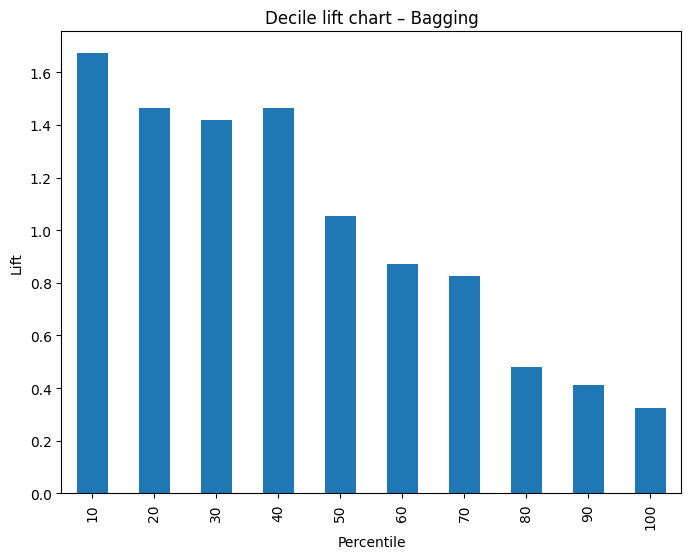

In [38]:

# creating a grid for bagging classifer 
bagging_parameter_grid = {
    'n_estimators': [50, 100, 300],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True],
}
# implementing grid search with 5-fold cross-validation for bagging classifier
bagging_cv = GridSearchCV(
    BaggingClassifier(random_state=1),  
    bagging_parameter_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
bagging_cv.fit(train_X, train_y) # fitting the model

best_bagging_method = bagging_cv.best_estimator_
print('Best Bagging parameters:', bagging_cv.best_params_)

bag_pred = best_bagging_method.predict(valid_X)
classificationSummary(valid_y, bag_pred) # evaluating the model

# Evaluate on validation
bagging_accuracy = accuracy_score(valid_y, bag_pred)
bagging_f1_score  = f1_score(valid_y, bag_pred)

# printing the results
print('\nValidation accuracy using best Bagging:', round(bagging_accuracy, 4)) 
print('Validation F1 using best Bagging:', round(bagging_f1_score, 4))
print('Accuracy improvement Bagging vs. single tree:', round(bagging_accuracy - metrics_tree['accuracy'], 4))

# Decile lift chart
df = pd.DataFrame({
    'predicted': best_bagging_method.predict_proba(valid_X)[:, 1],
    'actual': valid_y.values,
}).sort_values(by='predicted', ascending=False)

plt.figure(figsize=(8,6))
liftChart(df['actual'], labelBars=False)
plt.title('Decile lift chart – Bagging')
plt.show()

metrics_bag = {'accuracy': bagging_accuracy, 'f1': bagging_f1_score}


#### the first decile is over 1.6 which is already better than the decision tree which was around 1.35. This shows the best bagging model already predicted 25 percent better than best decision tree

#### if we compare the overall accuracy score bagging also did a better job and showed a 3.04 percent increase in accuracy, which is pretty significant and f1 score also improved by almost same amount.

#### Because its highest response/lift falls in deciles 2-3 rather than the top (first) decile, the single decision tree is not ranking well, indicating either poor calibration or weak ordering. The Bagging Classifier, on the other hand, exhibits the anticipated monotonic pattern: stronger ranking performance is reflected by the best response/lift being concentrated in the first decile and decreasing across subsequent deciles.

## (c)
Fit a random forest (use `RandomForestClassifier`) by tuning hyperparameters. Produce the gains and lift charts for the validation data. Compare the bagged tree to the random forest in terms of validation accuracy and lift on first decile. How are the two methods conceptually different? Extract and plot the feature importances from the final $\mathbf{best\_random\_forest}$ model. List the top 5 predictors of auction competitiveness.

Best RF params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
Confusion Matrix (Accuracy 0.7351)

       Prediction
Actual   0   1
     0 255  98
     1 111 325

Validation accuracy using Random Forest: 0.7351
Validation F1 using Random Forest: 0.7567

Top 5 predictors: 
OpenPrice                 0.346951
sellerRating              0.249753
endDay_Mon                0.057350
Duration                  0.054032
Category_Health/Beauty    0.036904
dtype: float64


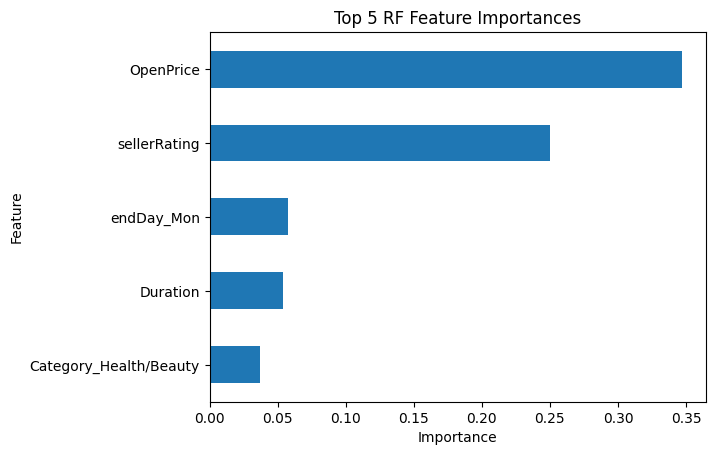

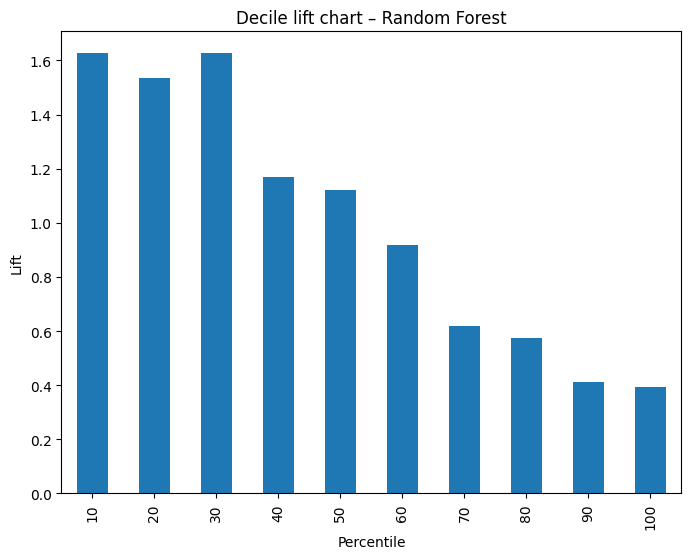

In [39]:
# Grid-search for RandomForestClassifier

random_param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 'log2'],
}
# implementing grid search with 5-fold cross-validation for random forest classifier
random_forest_cv = GridSearchCV(
    RandomForestClassifier(random_state=1),
    random_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
random_forest_cv.fit(train_X, train_y) # fitting the model

# getting the best estimator
best_random_forest = random_forest_cv.best_estimator_
print('Best RF params:', random_forest_cv.best_params_)

# Evaluate on validation
random_forest_pred = best_random_forest.predict(valid_X)
classificationSummary(valid_y, random_forest_pred)

# Evaluate on validation
random_forest_acc = accuracy_score(valid_y, random_forest_pred)
random_forest_f1  = f1_score(valid_y, random_forest_pred)
print('\nValidation accuracy using Random Forest:', round(random_forest_acc, 4))
print('Validation F1 using Random Forest:', round(random_forest_f1, 4))

# Top 5 feature importances converting to series 
top5features = pd.Series(best_random_forest.feature_importances_, index=train_X.columns)
top5_sorted = top5features.sort_values(ascending=False).head(5)
print('\nTop 5 predictors: ')
print(top5_sorted)

# bar plot to show feature importance
top5_sorted.sort_values().plot(kind='barh')
plt.title('Top 5 RF Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Decile lift chart
df = pd.DataFrame({
    'predicted': best_random_forest.predict_proba(valid_X)[:, 1],
    'actual': valid_y.values,
}).sort_values(by='predicted', ascending=False)

plt.figure(figsize=(8,6))
liftChart(df['actual'], labelBars=False)
plt.title('Decile lift chart – Random Forest')
plt.show()

metrics_rf = {'accuracy': random_forest_acc, 'f1': random_forest_f1, 'top5': top5.to_dict()}


#### Higher accuracy and F1 were attained by Random Forest when compared to bagging of decision trees, and its decile analysis validates superior ranking: Random Forest concentrates the most positives in the top (1st) decile and maintains stronger lift through deciles 2–3, while bagging's lift decreases beginning in deciles 2–3. This suggests that Random Forest more efficiently arranges cases, catching more true positives in the earliest deciles.

**Bagging (of decision trees): Bagging averages the predictions of numerous decision trees after training them on various bootstrap samples of the training data (or using a majority vote). The trees tend to be correlated because each split in each tree can take into account every feature; however, ensembling still significantly reduces variance without significantly altering bias. It is particularly useful when a single tree overfits but there are few and powerful key predictors. The idea is to use aggregation for stability and randomness from rows only (the bootstrap).**

**Random Forest: A random forest is bagging plus additional randomness at each split: each split takes into account a random subset rather than all features. At the expense of a slight increase in bias, this "random subspace" decorrelates trees more than simple bagging, producing a stronger variance reduction and generally better ranking/accuracy. Conceptually, aggregation for robustness and randomness from rows and columns.**

## (d)
Write a brief summary of your findings by answering the following questions:

Compare the best performance metrics (Accuracy, F1-Score) across the three models (Single Tree, Bagging, Random Forest).

Based on your results, which model is best suited for classifying auction competitiveness, and why? 

Using your Random Forest Feature Importance results, provide one actionable insight for an eBay seller based on the features that most predict a competitive auction.

**Comparing the Performance using validation**

Single Decision Tree: Accuracy = 0.7009, F1-Score = 0.7115

Bagging of Decision Trees: Accuracy = 0.7313, F1-Score = 0.7482

Random Forest: Accuracy = 0.7351, F1-Score = 0.7567

If we compare the accuracy and F1 score random forest shows better performance overall because it scored the best because it was able to predict better than both the other models.


**Best model and why**

Random Forest is the best overall. It achieves the highest F1-Score (0.7567) and the top Accuracy (0.7351) among the three. The ensemble reduces variance compared to a single tree and captures more signal than plain bagging in your split. Also, if we compare decile lift chart Random Forest concentrates the most positives in the top (1st) decile and maintains stronger lift through deciles 2–3, while bagging's lift decreases beginning in deciles 2–3. This suggests that Random Forest more efficiently arranges cases, catching more true positives in the earliest deciles.

**One actionable seller insight from Random Forest feature importance**

The top feature is OpenPrice and it is exteremly important.
Start the auction with a lower opening price (within a reasonable range for the item). This tends to attract more early bids, increases bidder activity, and raises the likelihood of a competitive auction.